In [1]:
###########################
###                     ###
###     Ensembling      ###
###                     ###
###########################

# Acknowledgement:
# This script was built by following this blog post:
# https://www.dataquest.io/blog/introduction-to-ensembles/

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest,
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew

import pickle
import xgboost
from sklearn.externals import joblib

In [12]:
data = joblib.load("data.pkl")
y = joblib.load("y.pkl")
X_train, X_test, y_train, y_test = train_test_split(data, y)

In [19]:
def get_models():
    models = joblib.load("models.pkl")
    # These modifications are for testing runtime speeds
    # and handling errors.
    models["RandomForest"] = RandomForestRegressor()
    # There is a bug in this code prevents XGBoost
    # from making its final base learner predictions.
    # This is a temporary fix.
    models["XGBoost"] = gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                   max_depth=2, max_features=10,loss="huber")
    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)#[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for k,v in models.items():
        print(k)
        print(rmse_cv(v).mean())

In [6]:
def train_base_learners(base_learners, inp, out):
    """Train all base learners in the library."""
    print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        print("done")

In [7]:
def predict_base_learners(pred_base_learners, inp):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))
    print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        print("%s..." % name, end=" ", flush=False)
        p = m.predict(inp)
        P[:, i] = p
        print("done")

    return P

In [8]:
def ensemble_predict(base_learners, meta_learner, inp):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp)
    return P_pred, meta_learner.predict(P_pred)

In [9]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner,

In [10]:
meta_learner = GradientBoostingRegressor(n_estimators=2000)

In [20]:
from sklearn.model_selection import KFold
# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), X_train.values, y_train.values, KFold(3))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, X_test)

Fitting final base learners...Fitting models.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
done
Generating cross-validated predictions...
Fitting models.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
Generating base learner predictions.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
Fold 1 done
Fitting models.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
Generating base learner predictions.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
Fold 2 done
Fitting models.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoost... done
BagRegressor... done
Generating base learner predictions.
Linear... done
LassoCV... done
ElasticNet... done
RandomForest... done
XGBoo

In [21]:
def rmse_cv_stack(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)
print(rmse_cv_stack(cv_meta_learner, P_pred, y_test).mean())

0.11904546517591683


In [22]:
r2_score(p, y_test)

0.9062936767602657

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


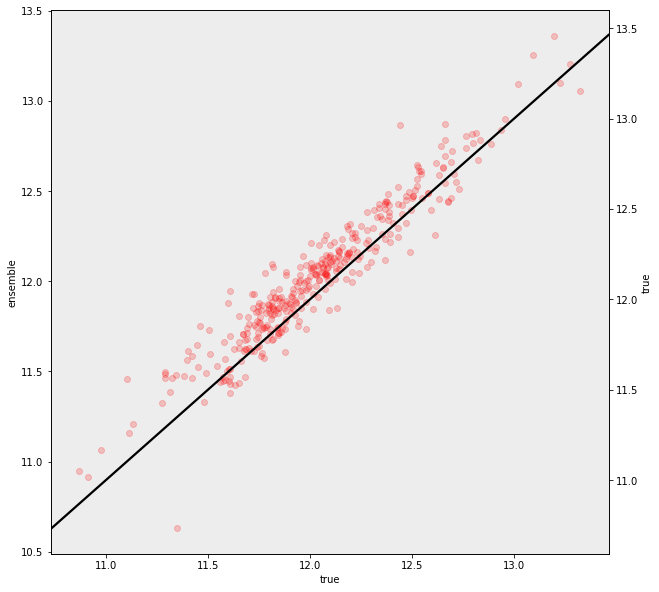

In [25]:
all_preds = pd.DataFrame({"ensemble": p,
                          "true": y_test})
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#ededed")
sns.regplot(x='true', y='ensemble', data=all_preds, ax=ax, color="red", fit_reg=False, scatter_kws={'alpha':0.2})
ax2 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax2, color="black", fit_reg=True, scatter_kws={'alpha': 0})